# Audio Cats/Dogs Classify DenseNet201

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import librosa

In [2]:
train_dir = '/kaggle/input/audio-cats-and-dogs/cats_dogs/train'
test_dir = '/kaggle/input/audio-cats-and-dogs/cats_dogs/test'
train_paths=[]
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        train_paths+=[(os.path.join(dirname, filename))]
test_paths=[]
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        test_paths+=[(os.path.join(dirname, filename))]

In [3]:
Name=['dog','cat']
N=list(range(len(Name)))    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))
Wrong_Name=['test','cats']
fix_mapping=dict(zip(Wrong_Name,Name))

# Sound to Image

In [4]:
train=[]
train_labels=[]
for path in train_paths:
    label=path.split('/')[-2]
    y, sr = librosa.load(path)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    img=log_mel_spectrogram
    img=cv2.resize(np.array(img),dsize=(128,128))
    X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    train+=[X*255]
    train_labels+=[normal_mapping[label]]
    
test=[]
test_labels=[]
for path in test_paths:
    label=path.split('/')[-2]
    y, sr = librosa.load(path)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    img=log_mel_spectrogram
    img=cv2.resize(np.array(img),dsize=(128,128))
    X=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    test+=[X*255]
    test_labels+=[normal_mapping[fix_mapping[label]]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [5]:
trainX = np.array(train)
testX = np.array(test)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)
train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)

In [6]:
trainx,testx,trainy,testy = train_test_split(
    trainX,train_labels,test_size=0.2,random_state=44)

In [7]:
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(168, 128, 128, 3)
(42, 128, 128, 3)
(168, 2)
(42, 2)


In [8]:
testx[0].min(),testx[0].max()

(0.0, 255.0)

In [9]:
trainy[0:3]

array([[1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [10]:
datagen = ImageDataGenerator(
             horizontal_flip=True,vertical_flip=True,
             rotation_range=20,zoom_range=0.2,
             width_shift_range=0.2,height_shift_range=0.2,
             shear_range=0.1,fill_mode="nearest")

# Model

In [11]:
pretrained_model3 = tf.keras.applications.DenseNet201(input_shape=(128,128,3),
                            include_top=False,weights='imagenet',pooling='avg')
pretrained_model3.trainable = False

2023-02-10 18:31:21.287751: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


74850304/74836368 [==============================] - 3s 0us/step


In [12]:
inputs3 = pretrained_model3.input
x3 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model3.output)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)
model = tf.keras.Model(inputs=inputs3, outputs=outputs3)

In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=16),
              validation_data=(testx,testy),epochs=100)

2023-02-10 18:31:28.750888: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
11/11 [==============================] - 19s 905ms/step - loss: 2.4429 - accuracy: 0.6190 - val_loss: 2.1776 - val_accuracy: 0.6667
Epoch 2/100
11/11 [==============================] - 6s 521ms/step - loss: 0.9418 - accuracy: 0.7262 - val_loss: 1.4425 - val_accuracy: 0.8095
Epoch 3/100
11/11 [==============================] - 6s 579ms/step - loss: 0.8761 - accuracy: 0.8036 - val_loss: 0.9444 - val_accuracy: 0.7857
Epoch 4/100
11/11 [==============================] - 6s 534ms/step - loss: 0.6852 - accuracy: 0.7976 - val_loss: 0.8326 - val_accuracy: 0.7619
Epoch 5/100
11/11 [==============================] - 6s 526ms/step - loss: 0.8491 - accuracy: 0.7262 - val_loss: 1.5036 - val_accuracy: 0.6667
Epoch 6/100
11/11 [==============================] - 6s 569ms/step - loss: 0.6334 - accuracy: 0.8095 - val_loss: 0.9060 - val_accuracy: 0.7381
Epoch 7/100
11/11 [==============================] - 6s 532ms/step - loss: 0.5386 - accuracy: 0.8095 - val_loss: 1.0446 - val_accuracy: 0.833

# Validation

In [15]:
y_pred = model.predict(testx)
y_pred2 = np.argmax(y_pred,axis=1)
ground = np.argmax(testy,axis=1)
print(classification_report(ground,y_pred2,target_names=Name,digits=4))

              precision    recall  f1-score   support

         dog     0.9412    0.8000    0.8649        20
         cat     0.8400    0.9545    0.8936        22

    accuracy                         0.8810        42
   macro avg     0.8906    0.8773    0.8792        42
weighted avg     0.8882    0.8810    0.8799        42



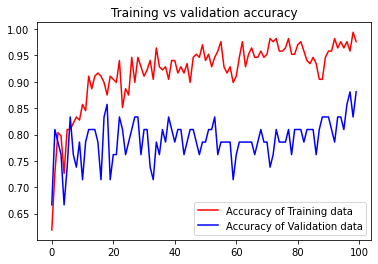

<Figure size 432x288 with 0 Axes>

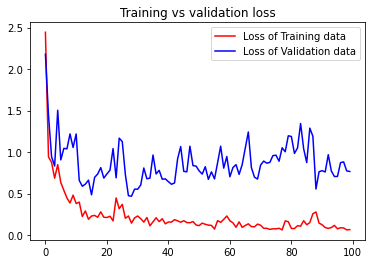

<Figure size 432x288 with 0 Axes>

In [16]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Predict

In [17]:
pred=model.predict(testX)
print(pred[0:3])

[[9.0882760e-01 9.1172360e-02]
 [9.9824154e-01 1.7585084e-03]
 [9.9993336e-01 6.6574161e-05]]


In [18]:
TEST_pred=[]
for item in pred:
    value=np.argmax(item)      
    TEST_pred+=[value]
TEST_true=test_labels
print(TEST_pred[0:3])
print(TEST_true[0:3])

[0, 0, 0]
[0 0 0]


In [19]:
from sklearn.metrics import classification_report
print(classification_report(TEST_true,TEST_pred,target_names=Name,digits=4))

              precision    recall  f1-score   support

         dog     1.0000    0.8214    0.9020        28
         cat     0.8864    1.0000    0.9398        39

    accuracy                         0.9254        67
   macro avg     0.9432    0.9107    0.9209        67
weighted avg     0.9339    0.9254    0.9240        67

